In [325]:
import torch
import time
import numpy as np
import seaborn as sns
from torch import nn
import matplotlib.pyplot as plt
from torch.distributions import Normal
import pandas as pd

In [326]:
def LDM_input_matrix(BE_data_train):
    """LDM matrix of covariates"""
    
    # Precalc of A
    A = (BE_data_train["Z"] + BE_data_train["N"]).values
    # a_vol term
    X = A[:, None]
    # a_surf term
    X = np.concatenate([X,  -A[:, None] ** (2/ 3)], axis = 1)
    # a_sym term
    X = np.concatenate([X, -((BE_data_train["N"] - BE_data_train["Z"]).values[:, None] ** 2) / (A[:, None])],
                       axis = 1)
    # a_C term
    
    X = np.concatenate([X, -((BE_data_train["Z"]).values[:, None] * ((BE_data_train["Z"]).values[:, None] - 1)) / (A[:, None] ** (1 / 3))],
                       axis = 1)
    return X


def BE_load_train(source, Z_range, N_range):
    """Function loads the BE dataset and returns training AME2003 data for given range Z and N
    
    Args:cor
        source: path to the source file
        Z_range: list of upper bound and lower bound on Z (inclusive)
        N_range: list of upper bound and lower bound on N (inclusive)
    Return:
        BE_data_train: PD DataFrame with Z, N, BE, BE_per_A
    """
    BE_data = pd.read_csv(source)
    BE_data_train = BE_data.query("AME2003 != '*'")[["Z", "N", "AME2003"]]
    BE_data_train = BE_data_train.astype('float')

    # BE per nucleus
    A = BE_data_train["Z"] + BE_data_train["N"]
    BE_per_nucleus = BE_data_train["AME2003"] / A
    BE_data_train = BE_data_train.assign(BE_per_A = BE_per_nucleus)
    
    # BE in range
    range_mask = (BE_data_train.Z >= Z_range[0]) & (BE_data_train.Z <= Z_range[1]) & \
                    (BE_data_train.N >= N_range[0]) & (BE_data_train.N <= N_range[1])
    BE_data_train = BE_data_train[range_mask]
    
    return BE_data_train

In [327]:
class MCElbo(torch.nn.Module):
    def __init__(self, nMC, x_dim, n):
        """torch.nn"""
        super(MCElbo, self).__init__()
        
        self.nMC = nMC
        self.x_dim = x_dim
        self.param_dim = x_dim
        self.n = n
        self.softplus = torch.nn.Softplus() # transformation of the variable
        
        ### Parameters for the variational posterior
        
        # Model parameters
        self.q_theta_m = torch.nn.Parameter(torch.randn(1,x_dim) * 0 + 10)
        self.q_theta_s = torch.nn.Parameter(torch.randn(1,x_dim))
        
        ### Prior distributions
        self.prior_theta_m = torch.randn(1,x_dim)
        self.prior_theta_s = torch.randn(1,x_dim)
         
        # Set appropriate values for prior likelihoods
        self.prior_theta_m.data.fill_(0)
        self.prior_theta_s.data.fill_(10)
        
        ### Current parameter state holder holder
        self.theta = torch.randn(1,x_dim)
        self.precision = torch.FloatTensor((1))
        self.precision.data.fill_(1/ (2.97 ** 2))

    
    def log_Normal(self, param, m, s):
        """Computes log likelihood of log_normal density
        Args:
            param: 1 X K dimensional tensor
            m: 1 X K dimensional mean tensor
            s: 1 X K dimensional std tensor
        """
        interm__ = ((param - m) / s).pow(2)
        log_prob = - len(param) * np.log(2 * np.pi) / 2 - torch.log(s).sum() - 0.5 * interm__.sum()
        return log_prob.reshape(1,1)
    
        
    def q_log(self):
        log_lkl = self.log_Normal(self.theta, self.q_theta_m, self.softplus(self.q_theta_s))  
        return log_lkl
        
    def pri_log(self):
        log_lkl = self.log_Normal(self.theta, self.prior_theta_m, self.prior_theta_s) 
        return log_lkl
    
    def generate_sample(self, n_var = 2):
        return Normal(0,1).sample((self.nMC,n_var,1))
    
    def sample_reparam_normal(self, param, m, s):
        return param.mul(self.softplus(s.T)).add(m.T)
    
        
    def regression_likelihood(self, x, y):
        """Returns dat likelihood for one MC sample"""
        y_fit = torch.matmul(x,self.theta.T).flatten()
        log_likelihood = (torch.log(self.precision) - np.log(2 * np.pi)) * 0.5 * self.n  - 0.5 * self.precision * torch.sum(torch.pow(y-y_fit, 2))    
        return log_likelihood
    
    def compute_elbo_loop(self, x, y):     
        
        z = self.generate_sample(n_var = self.param_dim)
        theta = self.sample_reparam_normal(z, self.q_theta_m, self.q_theta_s)
      
        

        loss = torch.randn(1,1)
        loss.data.fill_(0.0)
        
        for i in range(self.nMC):
            self.theta = theta[i].T
            
            q_likelihood = self.q_log()
            prior_likelihood = self.pri_log()
            data_likelihood = self.regression_likelihood(x, y)
            loss += data_likelihood + prior_likelihood - q_likelihood
        return loss / self.nMC
    
    def ModelString(self):
        return f"thetamean: {self.q_theta_m}"

In [328]:
torch.manual_seed(2)
source = "data_LDM_2019_BE_even_Z_even_N.csv"
Z_range =[0, 38]
N_range = [0, 48]
BE_data_train = BE_load_train(source, Z_range, N_range)

x_train = torch.tensor(LDM_input_matrix(BE_data_train[['Z', 'N', 'AME2003', 'BE_per_A']]), dtype = torch.float)
y_train = torch.tensor(BE_data_train.AME2003.values.flatten(), dtype = torch.float)

model = MCElbo(nMC= 5, x_dim = x_train.shape[1], n = len(y_train))

learning_rate = 2e-1
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 10000

# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute prediction
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 1000 == 999:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: 1833.3638916015625, Step [999/10000]
thetamean: Parameter containing:
tensor([[13.5710,  9.1128, 25.9634,  0.7190]], requires_grad=True)
Minutes remaining 0.6279757389832943
Loss: 681.1943359375, Step [1999/10000]
thetamean: Parameter containing:
tensor([[13.1738, 10.7616, 18.7919,  0.4971]], requires_grad=True)
Minutes remaining 0.5602722175363424
Loss: 460.23583984375, Step [2999/10000]
thetamean: Parameter containing:
tensor([[13.1748, 11.6571, 15.6562,  0.4375]], requires_grad=True)
Minutes remaining 0.500565211483011
Loss: 440.10400390625, Step [3999/10000]
thetamean: Parameter containing:
tensor([[13.3658, 12.2531, 15.6155,  0.4554]], requires_grad=True)
Minutes remaining 0.4262762719724162
Loss: 428.06817626953125, Step [4999/10000]
thetamean: Parameter containing:
tensor([[13.6155, 12.8538, 16.1359,  0.4856]], requires_grad=True)
Minutes remaining 0.3553906744445508
Loss: 418.05828857421875, Step [5999/10000]
thetamean: Parameter containing:
tensor([[13.8432, 13.3972, 16.

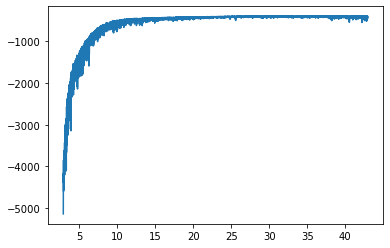

In [333]:
plt.plot(time_array[700:], -loss_array[700:])

In [345]:
means = np.mean(np.array(param_dictionary['q_theta_m']).reshape((len(np.array(param_dictionary['q_theta_m'])), model.x_dim))[-100:,:], axis = 0)
print(means)

[14.042075   13.860318   17.026789    0.53266835]


In [349]:
sds = np.mean(np.array(param_dictionary['q_theta_s']).reshape((len(np.array(param_dictionary['q_theta_s'])), model.x_dim))[-100:,:], axis = 0)
print(model.softplus(torch.tensor(sds)))

tensor([0.0051, 0.0176, 0.1556, 0.0020])


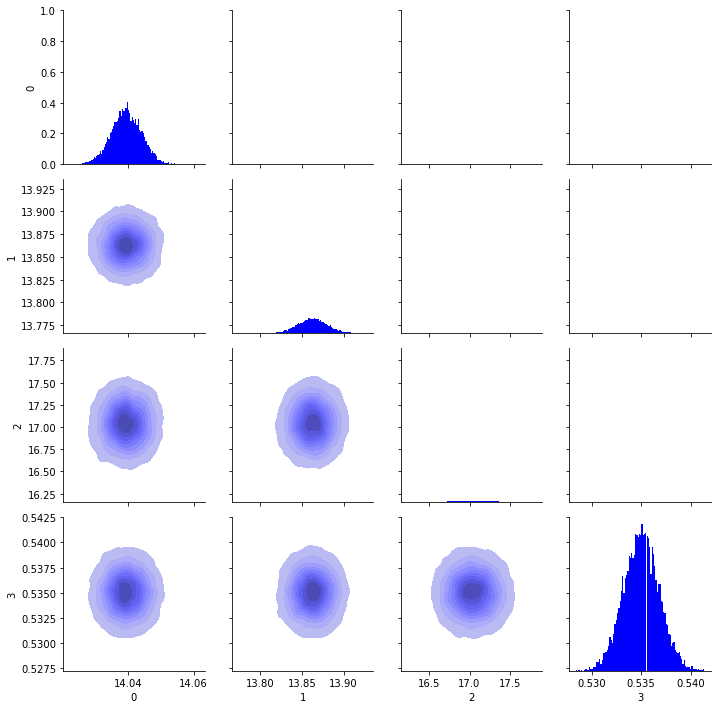

In [331]:
model.nMC = 10000
z = model.generate_sample(n_var = model.param_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, model.q_theta_s)

alpha = 1
bins = 100
g = sns.PairGrid(pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.x_dim)))
g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
plt.show()